In [1]:
import os
from pathlib import Path
import pandas as pd
import shutil
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

os.makedirs('datasets/processed', exist_ok=True)
os.makedirs('results', exist_ok=True)

In [2]:
# Process NSFW dataset (already has train/val/test splits!)
nsfw_path = Path('datasets/raw/nsfw_detection/out')

nsfw_data = []

for split in ['train', 'val', 'test']:
    split_path = nsfw_path / split
    
    # NSFW images
    nsfw_imgs = list((split_path / 'NSFW').glob('*.jpg'))
    for img_path in nsfw_imgs:
        nsfw_data.append({
            'image_path': str(img_path),
            'label': 'unsafe',
            'category': 'nsfw',
            'split': split,
            'source': 'nsfw_detection'
        })
    
    # Neutral (safe) images
    neutral_imgs = list((split_path / 'Neutral').glob('*.jpg'))
    for img_path in neutral_imgs:
        nsfw_data.append({
            'image_path': str(img_path),
            'label': 'safe',
            'category': 'neutral',
            'split': split,
            'source': 'nsfw_detection'
        })

nsfw_df = pd.DataFrame(nsfw_data)

print("NSFW Dataset Processing:")
print("="*60)
print(f"Total images: {len(nsfw_df)}")
print(f"\nSplit distribution:")
print(nsfw_df['split'].value_counts())
print(f"\nLabel distribution:")
print(nsfw_df['label'].value_counts())
print(f"\nLabel by split:")
print(pd.crosstab(nsfw_df['split'], nsfw_df['label']))

NSFW Dataset Processing:
Total images: 27532

Split distribution:
split
train    16528
test      5506
val       5498
Name: count, dtype: int64

Label distribution:
label
unsafe    16553
safe      10979
Name: count, dtype: int64

Label by split:
label  safe  unsafe
split              
test   2196    3310
train  6587    9941
val    2196    3302


In [3]:
# Process Violence dataset (needs manual train/val/test split)
violence_path = Path('datasets/raw/violence_safe')

violence_data = []

# Get all violent images
violent_imgs = list((violence_path / 'Graphically Violent Images').glob('*'))
violent_imgs = [f for f in violent_imgs if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

for img_path in violent_imgs:
    violence_data.append({
        'image_path': str(img_path),
        'label': 'unsafe',
        'category': 'violence',
        'source': 'violence_safe'
    })

# Get all safe images
safe_imgs = list((violence_path / 'Graphically Safe Images').glob('*'))
safe_imgs = [f for f in safe_imgs if f.suffix.lower() in ['.jpg', '.jpeg', '.png']]

for img_path in safe_imgs:
    violence_data.append({
        'image_path': str(img_path),
        'label': 'safe',
        'category': 'safe',
        'source': 'violence_safe'
    })

violence_df = pd.DataFrame(violence_data)

# Create train/val/test splits (80/10/10)
from sklearn.model_selection import train_test_split

# First split: 80% train, 20% temp
train_df, temp_df = train_test_split(
    violence_df, 
    test_size=0.2, 
    stratify=violence_df['label'],
    random_state=42
)

# Second split: split temp into 50/50 for val and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

train_df['split'] = 'train'
val_df['split'] = 'val'
test_df['split'] = 'test'

violence_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

print("\nViolence Dataset Processing:")
print("="*60)
print(f"Total images: {len(violence_df)}")
print(f"\nSplit distribution:")
print(violence_df['split'].value_counts())
print(f"\nLabel distribution:")
print(violence_df['label'].value_counts())
print(f"\nLabel by split:")
print(pd.crosstab(violence_df['split'], violence_df['label']))


Violence Dataset Processing:
Total images: 1161

Split distribution:
split
train    928
test     117
val      116
Name: count, dtype: int64

Label distribution:
label
safe      1096
unsafe      65
Name: count, dtype: int64

Label by split:
label  safe  unsafe
split              
test    110       7
train   876      52
val     110       6


In [4]:
# Combine both datasets
combined_df = pd.concat([nsfw_df, violence_df], ignore_index=True)

print("\n" + "="*60)
print("COMBINED DATASET:")
print("="*60)
print(f"Total images: {len(combined_df)}")
print(f"\nSplit distribution:")
print(combined_df['split'].value_counts())
print(f"\nLabel distribution:")
print(combined_df['label'].value_counts())
print(f"\nSource distribution:")
print(combined_df['source'].value_counts())

# Detailed breakdown
print(f"\n{'='*60}")
print("Detailed Breakdown:")
print('='*60)
for split in ['train', 'val', 'test']:
    split_data = combined_df[combined_df['split'] == split]
    print(f"\n{split.upper()}:")
    print(f"  Total: {len(split_data)}")
    print(f"  Safe: {len(split_data[split_data['label'] == 'safe'])}")
    print(f"  Unsafe: {len(split_data[split_data['label'] == 'unsafe'])}")
    print(f"  Ratio: {len(split_data[split_data['label'] == 'safe']) / len(split_data[split_data['label'] == 'unsafe']):.2f}")

# Save combined dataset
combined_df.to_csv('datasets/metadata/combined_dataset.csv', index=False)
print(f"\n✅ Saved combined dataset to datasets/metadata/combined_dataset.csv")


COMBINED DATASET:
Total images: 28693

Split distribution:
split
train    17456
test      5623
val       5614
Name: count, dtype: int64

Label distribution:
label
unsafe    16618
safe      12075
Name: count, dtype: int64

Source distribution:
source
nsfw_detection    27532
violence_safe      1161
Name: count, dtype: int64

Detailed Breakdown:

TRAIN:
  Total: 17456
  Safe: 7463
  Unsafe: 9993
  Ratio: 0.75

VAL:
  Total: 5614
  Safe: 2306
  Unsafe: 3308
  Ratio: 0.70

TEST:
  Total: 5623
  Safe: 2306
  Unsafe: 3317
  Ratio: 0.70

✅ Saved combined dataset to datasets/metadata/combined_dataset.csv


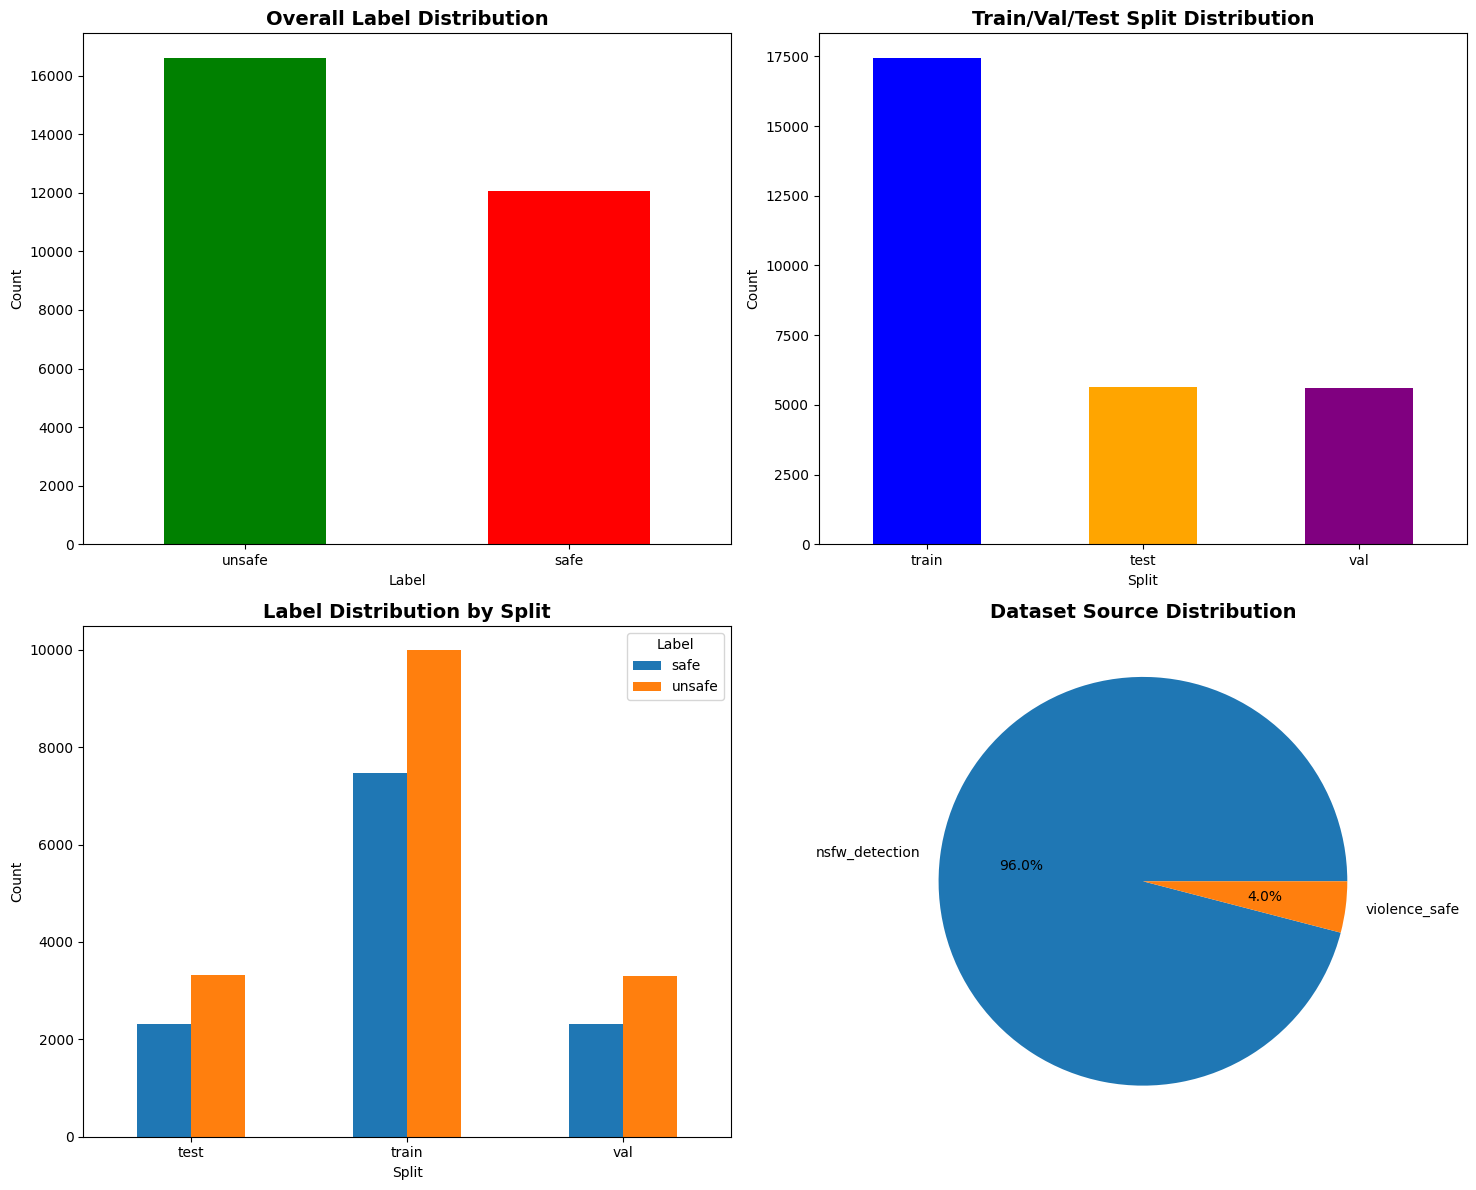

✅ Saved statistics to results/dataset_statistics.png


In [5]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Overall label distribution
ax1 = axes[0, 0]
combined_df['label'].value_counts().plot(kind='bar', ax=ax1, color=['green', 'red'])
ax1.set_title('Overall Label Distribution', fontsize=14, fontweight='bold')
ax1.set_xlabel('Label')
ax1.set_ylabel('Count')
ax1.tick_params(rotation=0)

# Plot 2: Split distribution
ax2 = axes[0, 1]
combined_df['split'].value_counts().plot(kind='bar', ax=ax2, color=['blue', 'orange', 'purple'])
ax2.set_title('Train/Val/Test Split Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Split')
ax2.set_ylabel('Count')
ax2.tick_params(rotation=0)

# Plot 3: Label by split
ax3 = axes[1, 0]
split_label_counts = pd.crosstab(combined_df['split'], combined_df['label'])
split_label_counts.plot(kind='bar', ax=ax3, stacked=False)
ax3.set_title('Label Distribution by Split', fontsize=14, fontweight='bold')
ax3.set_xlabel('Split')
ax3.set_ylabel('Count')
ax3.legend(title='Label')
ax3.tick_params(rotation=0)

# Plot 4: Source distribution
ax4 = axes[1, 1]
combined_df['source'].value_counts().plot(kind='pie', ax=ax4, autopct='%1.1f%%')
ax4.set_title('Dataset Source Distribution', fontsize=14, fontweight='bold')
ax4.set_ylabel('')

plt.tight_layout()
plt.savefig('results/dataset_statistics.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved statistics to results/dataset_statistics.png")

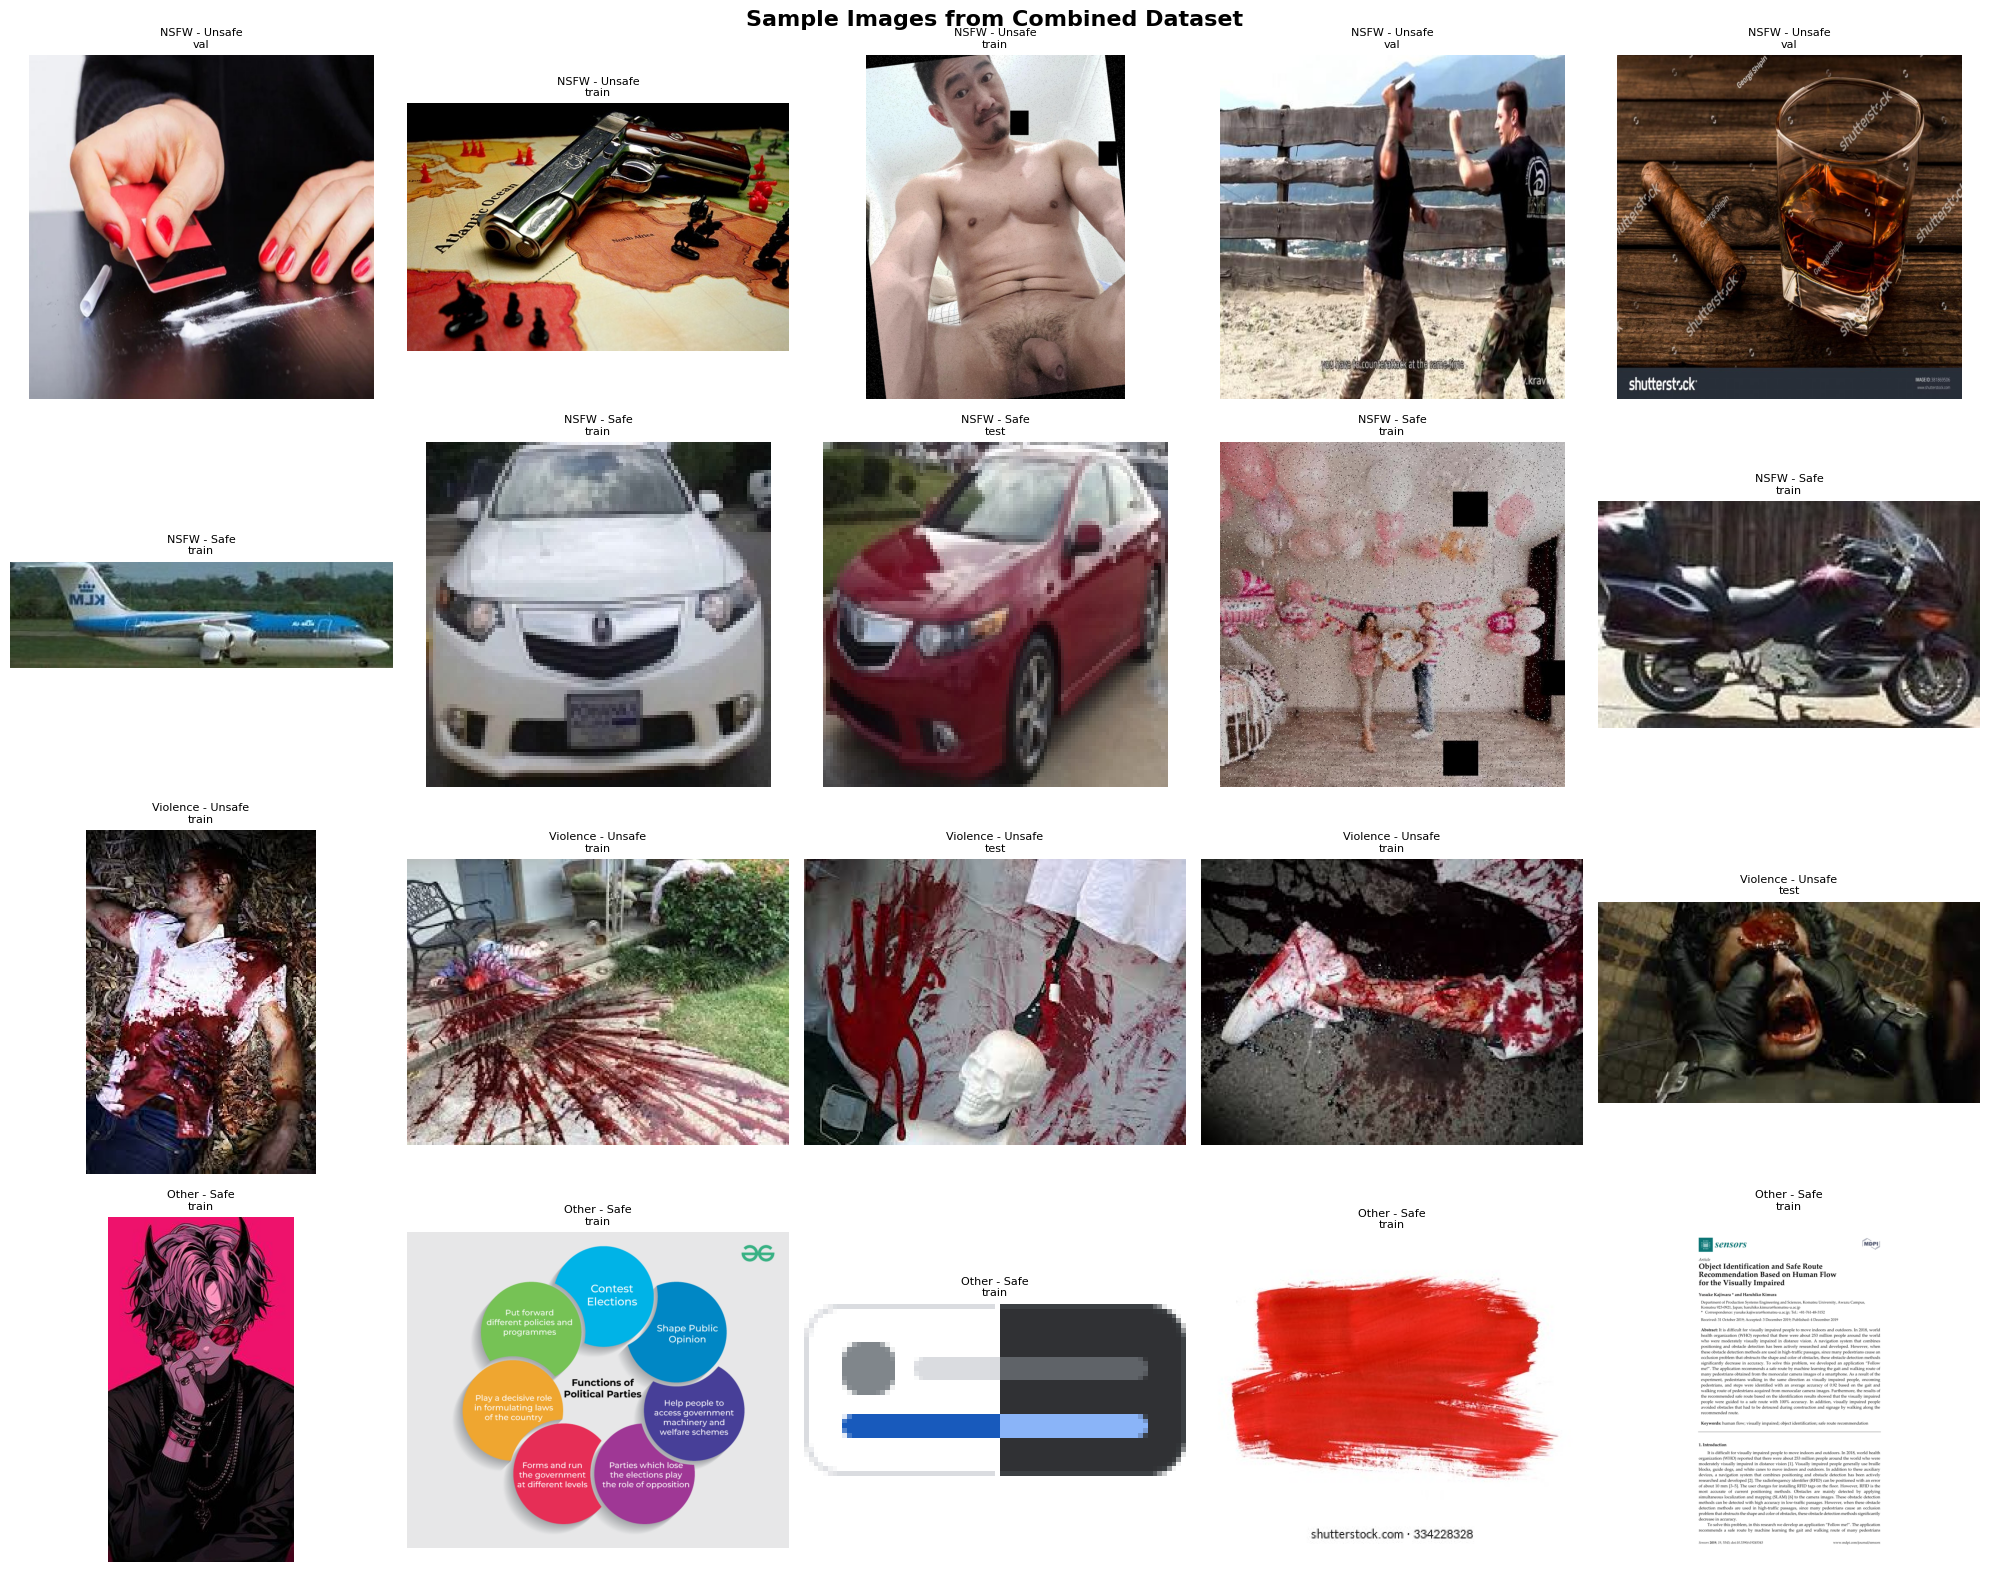

✅ Saved sample grid to results/sample_images_grid.png


In [ ]:
# Show sample images from each category
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

from PIL import Image
import numpy as np

# Get samples
sample_data = {
    'NSFW - Unsafe': combined_df[(combined_df['category'] == 'nsfw') & (combined_df['label'] == 'unsafe')].sample(5),
    'NSFW - Safe': combined_df[(combined_df['category'] == 'neutral') & (combined_df['label'] == 'safe')].sample(5),
    'Violence - Unsafe': combined_df[(combined_df['category'] == 'violence') & (combined_df['label'] == 'unsafe')].sample(min(5, len(combined_df[combined_df['category'] == 'violence']))),
    'Other - Safe': combined_df[(combined_df['category'] == 'safe') & (combined_df['label'] == 'safe')].sample(5),
}

for row_idx, (category, samples) in enumerate(sample_data.items()):
    for col_idx, (_, row) in enumerate(samples.iterrows()):
        if col_idx < 5:
            ax = axes[row_idx, col_idx]
            try:
                img = Image.open(row['image_path'])
                ax.imshow(img)
                ax.set_title(f"{category}\n{row['split']}", fontsize=8)
                ax.axis('off')
            except Exception as e:
                ax.text(0.5, 0.5, f'Error', ha='center', va='center')
                ax.axis('off')

plt.suptitle('Sample Images from Combined Dataset', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('results/sample_images_grid.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved sample grid to results/sample_images_grid.png") 